In [30]:
import pandas as pd
import numpy as np
import os
import time
import requests
from tqdm import tqdm
import json
from shapely.geometry import Polygon, MultiPolygon, LineString
from descartes import PolygonPatch
import matplotlib.pyplot as plt
%matplotlib inline

# http://z.ynet.co.il/short/content/2015/elections_map2015/

In [2]:
df = pd.read_csv(os.path.join('data', 'expc.csv'), encoding='iso8859_8')
df.head()

,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,דעם,ום,...,צק,ץ,ץז,ץי,ק,קי,קן,קף,ר,שס
0,שחר,7,516,371,0,371,17,2,0,0,...,0,0,0,0,0,0,0,0,0,33
1,תירוש,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,0,0,73
2,"ניר ח""ן",11,403,289,1,288,21,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,חצבה,13,502,403,0,403,44,2,0,0,...,0,0,0,0,3,0,0,0,0,2
4,נועם,15,302,217,2,215,1,4,0,0,...,0,0,0,0,0,0,0,0,0,25


In [3]:
df.shape

(1211, 49)

In [4]:
df['voting_percentage'] = df[r'מצביעים'] / df[r'בזב']
df['no_valid_voting_percentage'] = df[r'פסולים'] / df[r'מצביעים']
df.head()

,שם ישוב,סמל ישוב,בזב,מצביעים,פסולים,כשרים,אמת,ג,דעם,ום,...,ץז,ץי,ק,קי,קן,קף,ר,שס,voting_percentage,no_valid_voting_percentage
0,שחר,7,516,371,0,371,17,2,0,0,...,0,0,0,0,0,0,0,33,0.718992,0.000000
1,תירוש,10,333,237,2,235,4,3,0,0,...,0,0,0,0,0,0,0,73,0.711712,0.008439
2,"ניר ח""ן",11,403,289,1,288,21,0,0,0,...,0,0,0,0,0,0,0,2,0.717122,0.003460
3,חצבה,13,502,403,0,403,44,2,0,0,...,0,0,3,0,0,0,0,2,0.802789,0.000000
4,נועם,15,302,217,2,215,1,4,0,0,...,0,0,0,0,0,0,0,25,0.718543,0.009217


### Get polygons from Open Street Map:

In [5]:
def get_city_polygon(city_name):
    time.sleep(1)  # The openstreetmap api restricts to only one request in a sec
    full_city_name =  '{}+ישראל'.format(city_name)
    r = requests.get(r'https://nominatim.openstreetmap.org/search.php?q={}&polygon_geojson=1&format=json'.format(full_city_name))
    response = r.json()
    
    if r.json() == []: # sometimes the addition of 'Israel' results with no match
        time.sleep(1)  # The openstreetmap api restricts to only one request in a sec
        r = requests.get(r'https://nominatim.openstreetmap.org/search.php?q={}&polygon_geojson=1&format=json'.format(city_name))
        response = r.json()
    
    return response

In [6]:
openstreetmap_data = {name: get_city_polygon(name) for _, name in tqdm(df['שם ישוב'].iteritems())}

1211it [32:52,  2.15s/it]


In [8]:
with open(os.path.join(r'data', r'openstreetmap_settlement_data.json'), 'w') as jfile:
    json.dump(openstreetmap_data, jfile)

#### What did't we find

In [12]:
for settlement_name, settlement_data in openstreetmap_data.items():
    if not settlement_data: # == []
        print(settlement_name)

גיניגר
כפר הרא"ה
ביתן אהרן
פקיעין חדשה
ג'ש (גוש חלב)
דייר אל-אסד
טייבה (בעמק)
עין נקובא
עספיא
ריחאניה
מסעודין אל-עזאזמה
סואעד (חמרייה)
הוזייל (שבט)
עוקבי (בנו עוקבה)
אבו עבדון (שבט)
אסד (שבט)
אבו רוקייק (שבט)
אעצם (שבט)
קודייראת א-צאנע(שבט)
אטרש (שבט)
אבו רובייעה (שבט)
אבו ג'ווייעד (שבט)
אבו קורינאת (שבט)
עטאוונה (שבט)
תראבין א-צאנע (שבט)
קוואעין (שבט)
ג'נאביב (שבט)
רומת הייב
נצאצרה (שבט)
כרם יבנה (ישיבה)
כפר רוזנואלד (זרעית)
הוואשלה (שבט)
סייד (שבט)
ניצנה (קהילת חינוך)
גורנות הגליל
קבועה (שבט)
ח'ואלד
אבו קרינאת (יישוב)
תראבין א-צאנע(ישוב)
סעוה
כחלה
מחנה יפה
מחנה יוכבד
מחנה טלי
מצדות יהודה
באקה אל-גרביה
מעטפות חיצוניות


#### Find out which geojson types are

In [16]:
geojson_types_to_name = {}

for settlement_name, settlement_data in openstreetmap_data.items():
    if settlement_data: # != []
        geojson_type = settlement_data[0]['geojson']['type']  # find the first match type
        if not geojson_type in geojson_types_to_name:
            geojson_types_to_name[geojson_type] = []

        geojson_types_to_name[geojson_type].append(settlement_name)

In [17]:
{geo_type: len(names) for geo_type, names in geojson_types_to_name.items()}

{'Polygon': 946, 'LineString': 81, 'MultiPolygon': 11, 'Point': 126}

#### which settlements are not Polygon nor MultiPolygon?

In [21]:
print(geojson_types_to_name['LineString'] + geojson_types_to_name['Point'])

['מקווה ישראל', "כפר חסידים א'", 'חירות', 'חגלה', 'גבעת ח"ן', 'גן השומרון', 'דן', 'גת (קיבוץ)', 'לוחמי הגיטאות', 'גמזו', 'נחל עוז', 'חזון', 'שריגים (לי-און)', 'אחווה', 'מורשת', 'שני', 'מחנה מרים', 'יובל', 'חברון', 'כפר עציון', 'אלמוג', 'קדומים', 'תומר', 'אלקנה', 'מגדל עוז', 'תקוע', 'כוכב השחר', 'סלעית', 'ריחן', 'מבוא דותן', 'אריאל', 'בית אל', 'בית חורון', 'אלון מורה', 'מחולה', 'קליה', 'הר גילה', 'גלגל', 'ייט"ב', 'בקעות', 'גיתית', 'מכורה', 'מעלה אדומים', 'עופרה', 'אלעזר', 'שילה', 'חיננית', 'בית הערבה', 'מתתיהו', 'אפרת', 'ברקן', 'ניל"י', 'כרמל', 'מעון', 'עמנואל', 'ברכה', 'נעמ"ה', 'חרמש', 'תלם', 'אשכולות', 'נווה דניאל', 'נוקדים', 'גבעת זאב', 'טנא', 'דולב', 'עתניאל', 'יצהר', 'סוסיה', 'אורנית', 'איתמר', 'חגי', 'עלי', 'חשמונאים', 'סנסנה', 'ביתר עילית', 'קדר', 'טלמון', 'בת עין', 'גני מודיעין', 'עמיחי', 'קלע', 'כנרת (קבוצה)', 'יד רמב"ם', 'עין חרוד (מאוחד)', 'כפר יחזקאל', 'גבע', 'עין חרוד (איחוד)', 'חפצי-בה', 'יגור', 'כפר מל"ל', 'כפר יהושע', 'דבורה', 'מלאה', 'כפר ביל"ו', 'כפר הס', 'בית צבי', 'י

In [34]:
def reshaper(c):
    if len(np.shape(c)) == 3 or len(np.shape(c)) == 1:
        return c[0]
    return c

In [ ]:
# data = {}
# for i, row in valid_polys_df.iterrows():
#     city_name = row['שם ישוב']
#     data[city_name] = {}
#     data[city_name]['voting_percentage'] = row['voting_percentage']
#     data[city_name]['no_valid_voting_percentage'] = row['no_valid_voting_percentage']
    
#     geojson = row['polygon_geojson'][0]['geojson']
    
# #     if geojson['type'] == 'MultiPolygon':
# #         print(i, city_name)
# #         x = MultiPolygon(geojson['coordinates'])
            
# #     elif geojson['type'] == 'Polygon':
# #     print(i, city_name)
#     g = reshaper(geojson['coordinates'])
#     x = Polygon(g)
        
#     data[city_name]['geometry'] = x

In [59]:
# get Israel polygon's geojson
israel_geojson = requests.get(r'https://nominatim.openstreetmap.org/search.php?q=ישראל&polygon_geojson=1&format=json').json()
ymin, ymax, xmin, xmax = israel_geojson[0]['boundingbox']
il_coordinates = np.array(israel_geojson[0]['geojson']['coordinates'][0])
il_coordinates, ymin, ymax, xmin, xmax

array([[34.2674994, 31.2201289],
       [34.2675106, 31.2201026],
       [34.2681579, 31.2185852],
       ...,
       [34.2715715, 31.2231492],
       [34.2684909, 31.2206553],
       [34.2674994, 31.2201289]])

[[[34.7185675, 31.6213323], [34.7188743, 31.6198285], [34.7206473, 31.6176763], [34.7231905, 31.6158944], [34.7252955, 31.6155554], [34.727201, 31.6158843], [34.7309003, 31.6142005], [34.7317586, 31.6151324], [34.7303048, 31.6165166], [34.7316878, 31.6194447], [34.7329266, 31.6196388], [34.7330578, 31.62014], [34.7331008, 31.6206242], [34.7326147, 31.6213195], [34.7322929, 31.6220595], [34.7314936, 31.6222586], [34.7307501, 31.6222595], [34.7293473, 31.6209973], [34.7286215, 31.6211897], [34.7277781, 31.6204078], [34.7299704, 31.6188881], [34.7285627, 31.6169819], [34.726672, 31.6177326], [34.7246003, 31.6197855], [34.7225886, 31.6220695], [34.7216177, 31.6223427], [34.7194215, 31.6221536], [34.7185675, 31.6213323]]]


TypeError: list indices must be integers or slices, not str

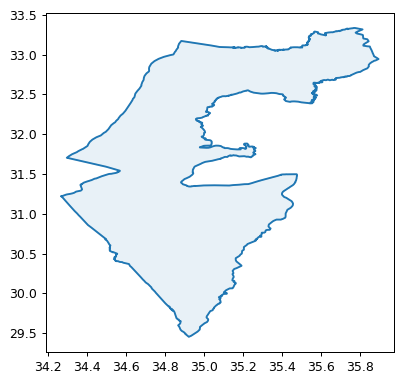

In [71]:
fig = plt.figure(1, figsize=(5,5), dpi=90)

ax = fig.add_subplot(111)
il_polygon = Polygon(il_coordinates)
il_outline_x, il_outline_y = il_polygon.exterior.xy
ax.plot(il_outline_x, il_outline_y)
ring_patch = PolygonPatch(il_polygon, alpha=0.1)
ax.add_patch(ring_patch)

# Plot all the cities
for city_name in geojson_types_to_name['Polygon']:
# for city_name in data:
    city_geometry = openstreetmap_data[city_name][0]['geojson']['coordinates']
    print(city_geometry)
    ring_patch = PolygonPatch(Polygon(city_geometry) #, ec=None, alpha=data[city_name]['voting_percentage'])
    ax.add_patch(ring_patch)

xrange = [float(xmin), float(xmax)]
yrange = [float(ymin), float(ymax)]
ax.set_xlim(*xrange)
# ax.set_xticks(list(range(*xrange)) + [xrange[-1]])
ax.set_ylim(*yrange)
# ax.set_yticks(list(range(*yrange)) + [yrange[-1]])
ax.set_aspect(1)
plt.subplots_adjust(right=2, top=2)

In [70]:
# Plot all the cities
for city_name in geojson_types_to_name['Polygon']:
# for city_name in data:
    city_geometry = openstreetmap_data[city_name][0]['geojson']['coordinates']
    print(city_geometry)
#     ring_patch = PolygonPatch(city_geometry)#, ec=None, alpha=data[city_name]['voting_percentage'])
#     ax.add_patch(ring_patch)

[[[34.7185675, 31.6213323], [34.7188743, 31.6198285], [34.7206473, 31.6176763], [34.7231905, 31.6158944], [34.7252955, 31.6155554], [34.727201, 31.6158843], [34.7309003, 31.6142005], [34.7317586, 31.6151324], [34.7303048, 31.6165166], [34.7316878, 31.6194447], [34.7329266, 31.6196388], [34.7330578, 31.62014], [34.7331008, 31.6206242], [34.7326147, 31.6213195], [34.7322929, 31.6220595], [34.7314936, 31.6222586], [34.7307501, 31.6222595], [34.7293473, 31.6209973], [34.7286215, 31.6211897], [34.7277781, 31.6204078], [34.7299704, 31.6188881], [34.7285627, 31.6169819], [34.726672, 31.6177326], [34.7246003, 31.6197855], [34.7225886, 31.6220695], [34.7216177, 31.6223427], [34.7194215, 31.6221536], [34.7185675, 31.6213323]]]
[[[34.8795737, 31.7527787], [34.8821486, 31.7494214], [34.8823952, 31.7491968], [34.8828434, 31.7497139], [34.883175, 31.7494245], [34.8835789, 31.7491765], [34.8838743, 31.7489016], [34.884036, 31.7489349], [34.8842242, 31.7491025], [34.8841969, 31.7488527], [34.884244, 3